<div>
  <h3><a href="#ExecutiveSummary" style="text-decoration: none;">1. Executive Summary</a></h3>
  <h3><a href="#Dataloading" style="text-decoration: none;">2. Data Loading</a></h3>
  <h3><a href="#preprocsessing" style="text-decoration: none;">3. Pre Processing</a></h3>
  <ul style="font-size: 18px;">
    <li><a href="#Missingvalue" style="text-decoration: none;">3.1 Dealing with Missing Value</a></li>
    <li><a href="#columntype" style="text-decoration: none;">3.2 Dealing with Column Type</a></li>
    <li><a href="#aggregatingdata" style="text-decoration: none;">3.3 Aggregating Products Quantity</a></li>
  </ul>
  <h3><a href="#featureengineering" style="text-decoration: none;">4. Feature Engineering</a></h3>
  <ul style="font-size: 18px;">
    <li><a href="#timebased" style="text-decoration: none;">4.1 Creating Time-Based Feature</a></li>
    <li><a href="#lag" style="text-decoration: none;">4.2 Lag and Moving Average Feature for Quantity</a></li>
  </ul>
  <h3><a href="#model" style="text-decoration: none;">5. Building Model</a></h3>
  <ul style="font-size: 18px;">
    <li><a href="#ft" style="text-decoration: none;">5.1 Define Features and Target</a></li>
    <li>
      <a href="#lr" style="text-decoration: none;">5.2 Linear Regression Model</a>
      <ul style="font-size: 16px;">
        <li><a href="#evalr" style="text-decoration: none;">5.2.1 Linear Regression Model Evaluation</a></li>
      </ul>
    </li>
    <li>
      <a href="#rf" style="text-decoration: none;">5.3 Random Forest Model</a>
      <ul style="font-size: 16px;">
        <li><a href="#evarf" style="text-decoration: none;">5.3.1 Random Forest Model Evaluation</a></li>
      </ul>
    </li>
    <li>
      <a href="#lstm" style="text-decoration: none;">5.4 LSTM Model</a>
      <ul style="font-size: 16px;">
        <li><a href="#evalstm" style="text-decoration: none;">5.4.1 LSTM Evaluation</a></li>
      </ul>
    </li>
  </ul>
  <h3><a href="#for" style="text-decoration: none;">6. Demand Forecast</a></h3>
  <ul style="font-size: 18px;">
    <li><a href="#toppro" style="text-decoration: none;">6.1 Demand Forecast for the Top Product</a></li>
    <li><a href="#overtime" style="text-decoration: none;">6.2 Demand Forecast for a Specific Product Over Time</a></li>
    <li><a href="#out" style="text-decoration: none;">6.3 Demand Forecast for Top Products That Were Out of Stock</a></li>
    <li><a href="#outtotal" style="text-decoration: none;">6.4 Bar chart showing the top out of stock prodcut total demand forcast</a></li>
  </ul>
</div>


<a id="ExecutiveSummary"></a>
# 1. Executive Summary: Development of Quantity Forecasting Model


## Introduction

In the development of our quantity forecasting model, we adopted a comprehensive and iterative approach to enhance the accuracy and reliability of our predictions.

## Model Evaluation and Selection

Our methodology involved the evaluation of three distinct models. Among these, the **Random Forest model** emerged as the most effective, characterized by:

- **Mean Absolute Error (MAE):** Achieved an MAE of 25.5, which is considerable given the challenges outlined below.
- **Product Range:** The model was tested across a vast range of products, approximately 608,000, with quantities varying significantly from as few as 20 to several millions.

The Random Forest model's performance under these conditions demonstrates its robust capability to forecast demand across our diverse product portfolio.

## Methodological Enhancements

### Initial Experiments

Initial experiments with basic models and time series features yielded less satisfactory results, with some models exhibiting a MAE as high as 500.

### Refinement with Advanced Features

To refine our approach, we introduced lag features and moving average windows, focusing on:
- **Capturing Trends and Seasonality:** This led to the identification of an optimal configuration of four lag features and a moving average window of four.
- **Optimization:** This balance optimized model performance while minimizing feature complexity and computational demands.

## Strategic Focus

Given constraints on computing resources, our strategy also included:

- **Prioritizing Predictions:** Focusing on the top 50 revenue-contributing products and the top 50 products experiencing zero or negative sales to ensure precise inventory levels and address potential revenue losses.



<a id="Dataloading"></a>
# 2. Data Loading 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

transaction_data = pd.read_csv('transactions_dataset.csv',sep=';')
transaction_data.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051


<a id="preprocsessing"></a>
# 3. Pre Procsessing 


- In the preprocessing phase, our initial action was to remove the row containing the null value.
- Following that, we converted the data type of the "date_order" column to datetime.
-  To align with our decision to conduct forecasts on a weekly basis, we aggregated the quantities for each product weekly.

<a id="Missingvalue"></a>
### 3.1 Dealing with missing value  

In [3]:
# Checking for null values
print(transaction_data.isnull().sum())

# Dropping rows with any null values
transaction_data_cleaned = transaction_data.dropna()

date_order       0
date_invoice     1
product_id       0
client_id        0
sales_net        0
quantity         0
order_channel    0
branch_id        0
dtype: int64


<a id="columntype"></a>
### 3.2 Dealing with column type 

In [4]:
transaction_data['date_order'] = pd.to_datetime(transaction_data['date_order'])
transaction_data['date_invoice'] = pd.to_datetime(transaction_data['date_invoice'])

<a id="aggregatingdata"></a>
### 3.2 Aggreagting Products by weekley quantity sold 

In [5]:
# Aggregate data to weekly sales by product
transaction_data.set_index('date_order', inplace=True)
weekly_sales = transaction_data.groupby('product_id').resample('W').agg({'quantity': 'sum'}).reset_index()

In [6]:
weekly_sales

,product_id,date_order,quantity
0,15,2019-01-06,1630
1,15,2019-01-13,201
2,15,2019-01-20,734
3,15,2019-01-27,41
4,15,2019-02-03,0
...,...,...,...
16127244,3238800,2019-07-21,35
16127245,3238809,2018-06-17,5
16127246,3238811,2018-02-25,21
16127247,3238819,2018-05-13,3


<a id="featureengineering"></a>
# 4. Feature engineering

- During the feature engineering process, We decided that implementing new features could enhance the model's performance.
-  After thorough experimentation in previous attempts , we determined that creating lag and moving average features for quantity attributes was the most effective technique.
-   Through multiple trials, we identified that utilizing four lag periods and a window size of four strikes the ideal balance between model performance and computational constraints

<a id="timebased"></a>
### 4.1 Create time-based features 

In [7]:
# Create time-based features
weekly_sales['week_of_year'] = weekly_sales['date_order'].dt.isocalendar().week
weekly_sales['year'] = weekly_sales['date_order'].dt.year

In [8]:
# Since we're working with time series data, it's important to sort the data
weekly_sales.sort_values(by=['product_id', 'date_order'], inplace=True)

<a id="lag"></a>
### 4.1 Creating lag feature for quantity and moving average 

In [9]:
# Create lag features for quantity sold
for lag in [1, 2, 3, 4]:
    weekly_sales[f'quantity_lag_{lag}'] = weekly_sales.groupby('product_id')['quantity'].shift(lag)

In [10]:
# Moving average of quantity sold
weekly_sales['quantity_ma_4'] = weekly_sales.groupby('product_id')['quantity'].transform(lambda x: x.rolling(window=4).mean())

In [11]:
# Drop rows with NaN values created by lag features
weekly_sales.dropna(inplace=True)

In [12]:
weekly_sales

,product_id,date_order,quantity,week_of_year,year,quantity_lag_1,quantity_lag_2,quantity_lag_3,quantity_lag_4,quantity_ma_4
4,15,2019-02-03,0,5,2019,41.0,734.0,201.0,1630.0,244.00
5,15,2019-02-10,2015,6,2019,0.0,41.0,734.0,201.0,697.50
6,15,2019-02-17,1567,7,2019,2015.0,0.0,41.0,734.0,905.75
7,15,2019-02-24,1403,8,2019,1567.0,2015.0,0.0,41.0,1246.25
8,15,2019-03-03,507,9,2019,1403.0,1567.0,2015.0,0.0,1373.00
...,...,...,...,...,...,...,...,...,...,...
16127240,3238800,2019-06-23,70,25,2019,0.0,0.0,0.0,0.0,17.50
16127241,3238800,2019-06-30,0,26,2019,70.0,0.0,0.0,0.0,17.50
16127242,3238800,2019-07-07,0,27,2019,0.0,70.0,0.0,0.0,17.50
16127243,3238800,2019-07-14,0,28,2019,0.0,0.0,70.0,0.0,17.50


<a id="model"></a>
# 5. Bullding Model 

- We opted to explore three distinct models: Linear Regression, Random Forest, and LSTM.
- In assessing our models' performance, we employed the Mean Absolute Error (MAE) metric. This choice allows us to compare the model's performance with the average quantity per week we possess and align it with our business objectives.
-  Ultimately, we settled on employing the Random Forest model due to its notably reasonable MAE.
-  we also showed a corrlation matrix for some models created to try to see which featuers affect the most 

<a id="ft"></a>
### 5.1 Define Feautures and target 

In [13]:
# Define features and target variable
features = ['week_of_year', 'year', 'quantity_lag_1', 'quantity_lag_2', 'quantity_lag_3', 'quantity_lag_4', 'quantity_ma_4']
target = 'quantity'

<a id="lr"></a>
### 5.2 Linear Regression Model

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [15]:
# Splitting the data into training and testing sets
X = weekly_sales[features]
y = weekly_sales[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [16]:
# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

<a id="evalr"></a>
### 5.2.1 Linear Regression Model Evaluation

In [17]:
# Predict on the test set and evaluate
y_pred = lr_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [18]:
print(f'Linear Regression MAE: {mae}')
print(f'Linear Regression RMSE: {rmse}')


Linear Regression MAE: 2.0468547680536363e-09
Linear Regression RMSE: 2.5216592071210522e-08


<a id="rf"></a>
### 5.3 Random Forest  Model

In [19]:
# Define features and target variable
RF_features = ['week_of_year', 'year', 'quantity_lag_1', 'quantity_lag_2', 'quantity_lag_3', 'quantity_lag_4', 'quantity_ma_4']
RF_target = 'quantity'

In [20]:
# Splitting the data into training and testing sets
X = weekly_sales[RF_features]
y = weekly_sales[RF_target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [21]:
#Random Forest Regressor
model = RandomForestRegressor(n_estimators=150, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150, random_state=42)

In [22]:
# Predict on the test set and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

<a id="evarf"></a>
### 5.3.1 Random Forest Model Evaluation

In [23]:
print(f'MAE: {mae}, RMSE: {rmse}')

MAE: 25.49731375619139, RMSE: 1302.0745256897085


In [48]:
from joblib import dump, load

# Save the model to a file
dump(model, 'random_forest_final_Demand_model.joblib')


['random_forest_final_Demand_model.joblib']

In [24]:
from sklearn.linear_model import LinearRegression

coefficients = lr_model.coef_

coefficients_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Displaying coefficients
print(coefficients_df.sort_values(by='Coefficient', ascending=False))


          Feature   Coefficient
6   quantity_ma_4  4.000000e+00
1            year  5.880829e-11
0    week_of_year  6.081497e-12
5  quantity_lag_4 -1.715075e-13
3  quantity_lag_2 -1.000000e+00
4  quantity_lag_3 -1.000000e+00
2  quantity_lag_1 -1.000000e+00


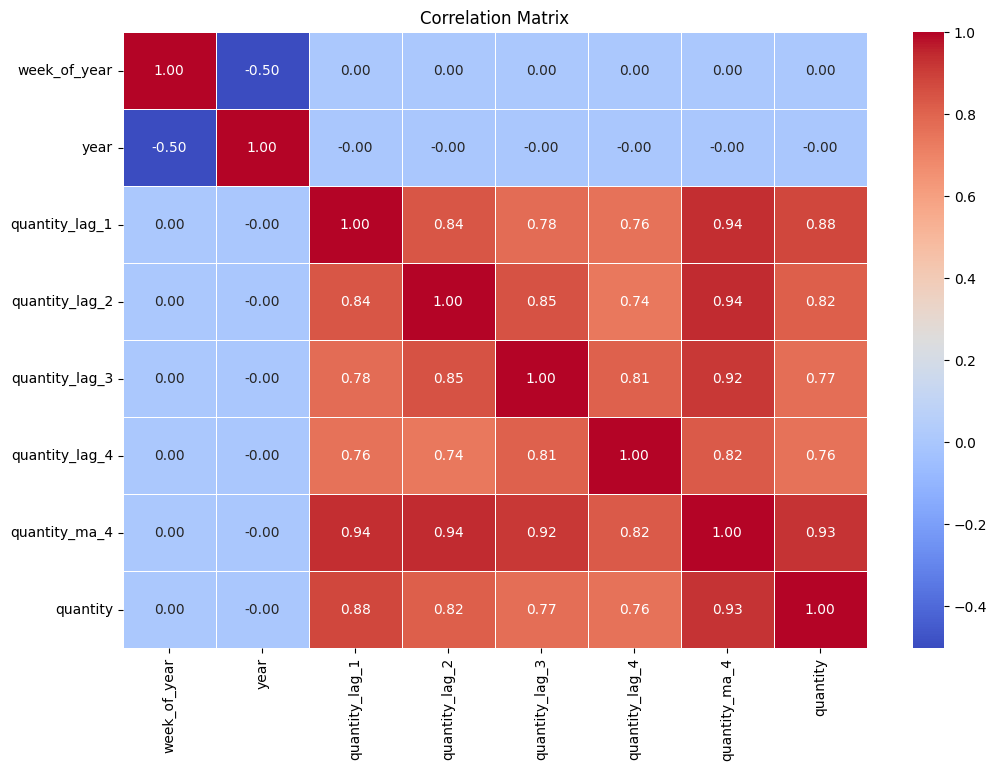

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Let's include only the features used in the model plus the target variable for the correlation matrix
features_and_target = RF_features + [RF_target] 

# Calculating the correlation matrix
correlation_matrix = weekly_sales[features_and_target].corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


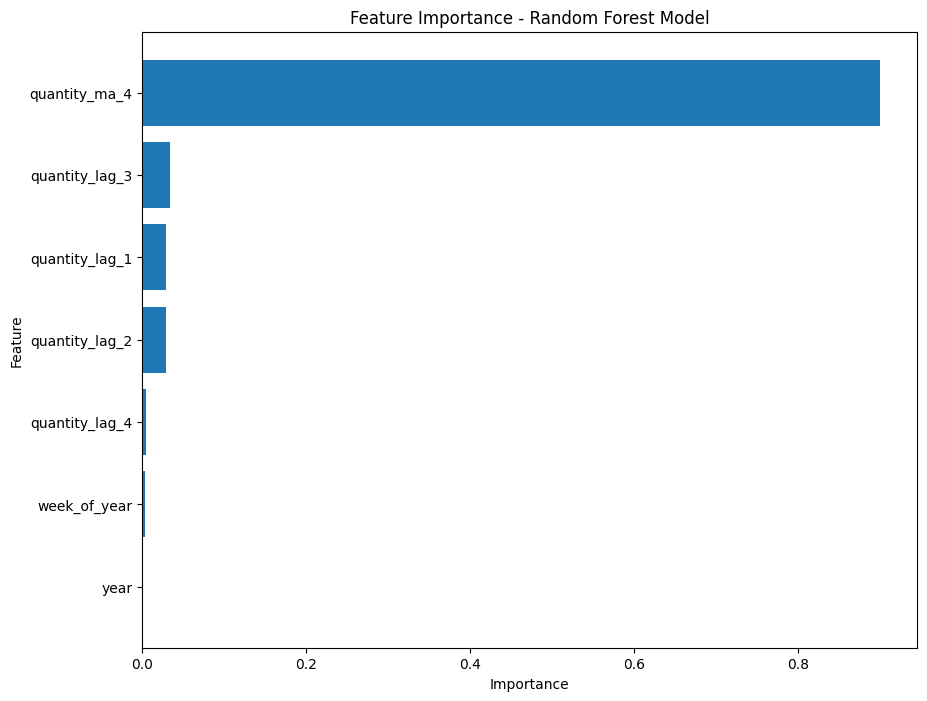

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 

# Assuming `model` is your trained RandomForestRegressor
feature_importances = model.feature_importances_

# Get the feature names from the column names of your input features
features = RF_features  

# Create a DataFrame to hold the feature names and their importance scores
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


<a id="lstm"></a>
### 4.4 LSTM  Model

In [38]:
# Define features and target variable
LSTM_features = ['week_of_year', 'year', 'quantity_lag_1', 'quantity_lag_2', 'quantity_lag_3', 'quantity_lag_4', 'quantity_ma_4']
LSTM_target = 'quantity'

In [43]:
# Updating TensorFlow
!pip install --upgrade tensorflow

# Updating Keras
!pip install --upgrade keras

  Using cached keras-3.0.5-py3-none-any.whl.metadata (4.8 kB)
Using cached keras-3.0.5-py3-none-any.whl (1.0 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Select features and target
lstm_X = weekly_sales[LSTM_features]
lstm_y = weekly_sales[LSTM_target]

# Normalize features
lstm_scaler = MinMaxScaler(feature_range=(0, 1))
lstm_X_scaled = lstm_scaler.fit_transform(lstm_X)

# Reshape lstm_X to be [samples, time steps, features]
lstm_X_scaled = lstm_X_scaled.reshape((lstm_X_scaled.shape[0], 1, lstm_X_scaled.shape[1]))

# Split into training and testing sets
lstm_X_train, lstm_X_test, lstm_y_train, lstm_y_test = train_test_split(lstm_X_scaled, lstm_y, test_size=0.2, random_state=42)

# Define a simplified LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(20, input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2])))  # Reduced the number of LSTM units to 20
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Fit the model with fewer epochs and a larger batch size
lstm_model.fit(lstm_X_train, lstm_y_train, epochs=50, batch_size=128, validation_data=(lstm_X_test, lstm_y_test), verbose=2, shuffle=False)


Epoch 1/50
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x000001E489AF20E0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x000001E489AF20E0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Origi

<a id="evalstm"></a>
### 5.4.1 LSTM Model Evaluation

In [46]:
from sklearn.metrics import mean_absolute_error

# Predicting on the test set
lstm_predictions = lstm_model.predict(lstm_X_test)

lstm_y_test_true = np.array(lstm_y_test).reshape(-1, 1)
lstm_predictions = lstm_predictions.reshape(-1, 1)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(lstm_y_test_true, lstm_predictions)
print(f'Mean Absolute Error (MAE): {mae}')


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000001E489AF2200>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000001E489AF2200>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Orig

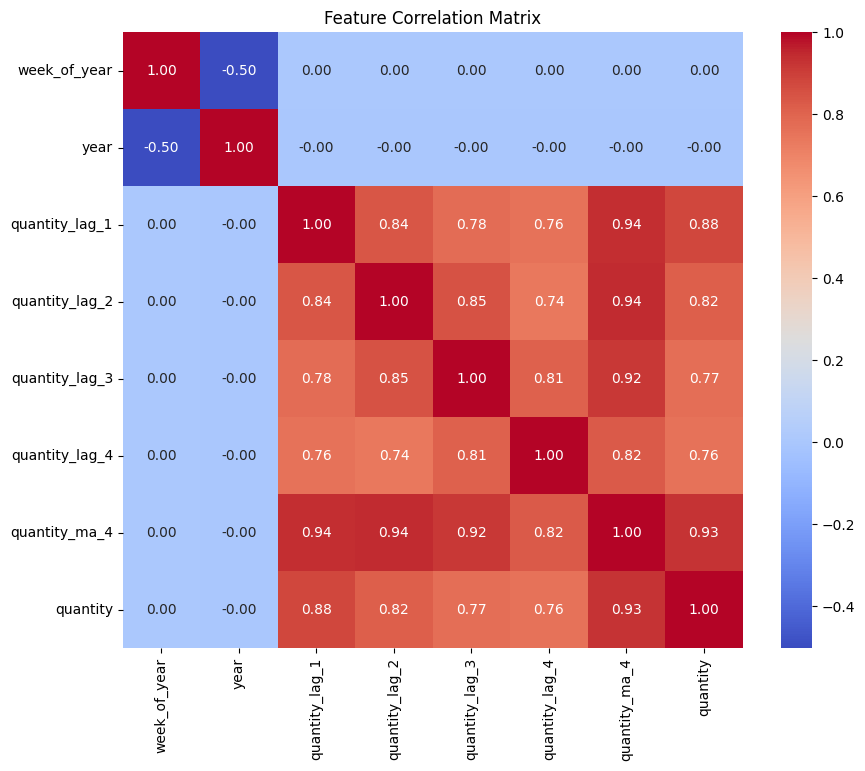

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

features_and_target = LSTM_features + [LSTM_target]  # Add the target column name if necessary

# Compute the correlation matrix
corr_matrix = weekly_sales[features_and_target].corr()

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Matrix')
plt.show()


<a id="for"></a>
# 6. Demand Forcast using Randome Forest model


Throughout the quantity forecasting process, we employed the Random Forest model
-  Our strategy revolved around targeting two primary categories
-  The first category prioritized products that significantly contributed to our revenue in terms of both sales and quantity. Our objective here was to safeguard this substantial portion of our business
-  The second category encompassed products that frequently appeared in the unfulfilled orders segment, where transactions were either zero or negative. We inferred that these products were likely out of stock during the order date and aimed to address this issue accordingly.

<a id="toppro"></a>
### 6.1 Demand Forcast for our the top products 

In [29]:
from datetime import datetime, timedelta
import pandas as pd

top_products = transaction_data.groupby('product_id')['quantity'].sum().nlargest(50).index
product_ids = top_products.tolist()

# Start from a specific date for future predictions
start_date = datetime(2019, 10, 1)  # Adjust as necessary
future_dates = [start_date + timedelta(weeks=w) for w in range(24)]

# Create the prediction DataFrame
future_df = pd.DataFrame([(date, pid) for date in future_dates for pid in product_ids], columns=['date', 'product_id'])

# Initialize columns for lag and moving average features
for lag in range(1, 5):
    future_df[f'quantity_lag_{lag}'] = None
future_df['quantity_ma_4'] = None

# Add 'week_of_year' and 'year' for these future dates
future_df['week_of_year'] = future_df['date'].dt.isocalendar().week
future_df['year'] = future_df['date'].dt.year

# Function to fill in the lag and moving average features for each row in future_df
def fill_features(row, historical_data):
    product_id = row['product_id']
    for lag in range(1, 5):
        # Attempt to find the lagged quantity from historical data
        lag_date = row['date'] - timedelta(weeks=lag)
        lag_quantity = historical_data[(historical_data['product_id'] == product_id) & 
                                       (historical_data['date'] == lag_date)]['quantity'].sum()
        row[f'quantity_lag_{lag}'] = lag_quantity
    
    # Calculate moving average
    ma_periods = historical_data[(historical_data['product_id'] == product_id) & 
                                 (historical_data['date'] < row['date'])].tail(4)['quantity']
    row['quantity_ma_4'] = ma_periods.mean() if not ma_periods.empty else 0
    
    return row

# Update historical_data to match the format used in fill_features
historical_data = weekly_sales[['date_order', 'product_id', 'quantity']].rename(columns={'date_order': 'date'})
historical_data['date'] = pd.to_datetime(historical_data['date'])

# Apply the function to fill features
future_df = future_df.apply(lambda row: fill_features(row, historical_data), axis=1)

# Ensure the features are in the correct order
features = ['week_of_year', 'year', 'quantity_lag_1', 'quantity_lag_2', 'quantity_lag_3', 'quantity_lag_4', 'quantity_ma_4']

# Predict using the RandomForest model
future_df['predicted_quantity'] = model.predict(future_df[features])

print(future_df[['date', 'product_id', 'predicted_quantity']])


           date  product_id  predicted_quantity
0    2019-10-01     2681878        1.331436e+06
1    2019-10-01      463156        1.222284e+06
2    2019-10-01      539670        1.455155e+06
3    2019-10-01      932375        8.079613e+05
4    2019-10-01     1180925        7.910489e+05
...         ...         ...                 ...
1195 2020-03-10     1003017        5.586381e+05
1196 2020-03-10      246501        4.970742e+05
1197 2020-03-10     2551513        5.611128e+05
1198 2020-03-10      275763        4.970742e+05
1199 2020-03-10     1328617        4.049344e+05

[1200 rows x 3 columns]


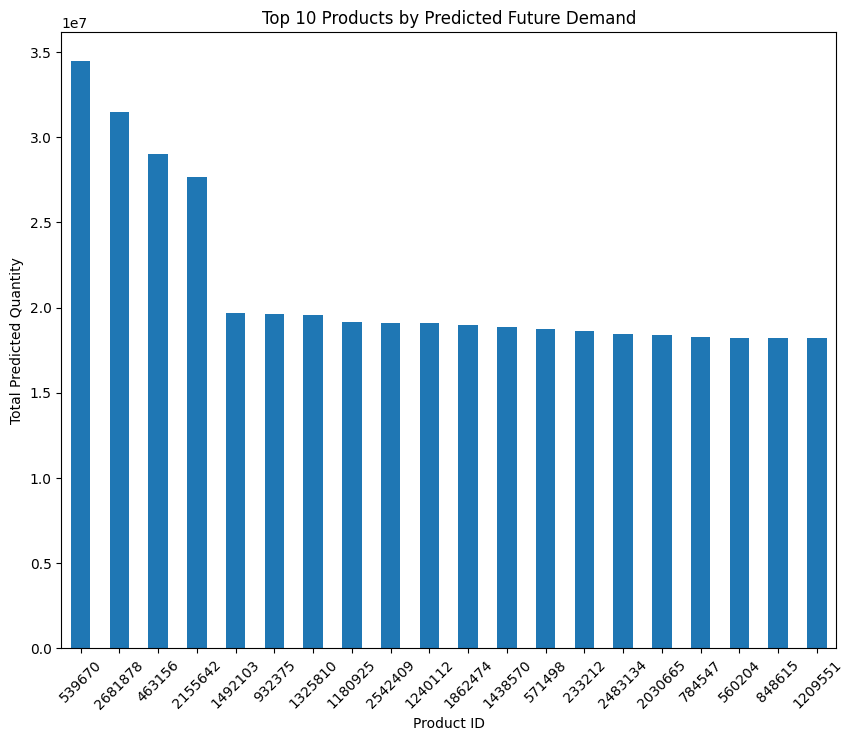

In [31]:
import matplotlib.pyplot as plt

# Sum predicted quantities by product_id
product_sum_predictions = future_df.groupby('product_id')['predicted_quantity'].sum().nlargest(20)

# Create a bar chart
plt.figure(figsize=(10, 8))
product_sum_predictions.plot(kind='bar')
plt.title('Top 10 Products by Predicted Future Demand')
plt.xlabel('Product ID')
plt.ylabel('Total Predicted Quantity')
plt.xticks(rotation=45)
plt.show()


<a id="overtime"></a>
### 6.2 Demand Forcast for a specific product over time  

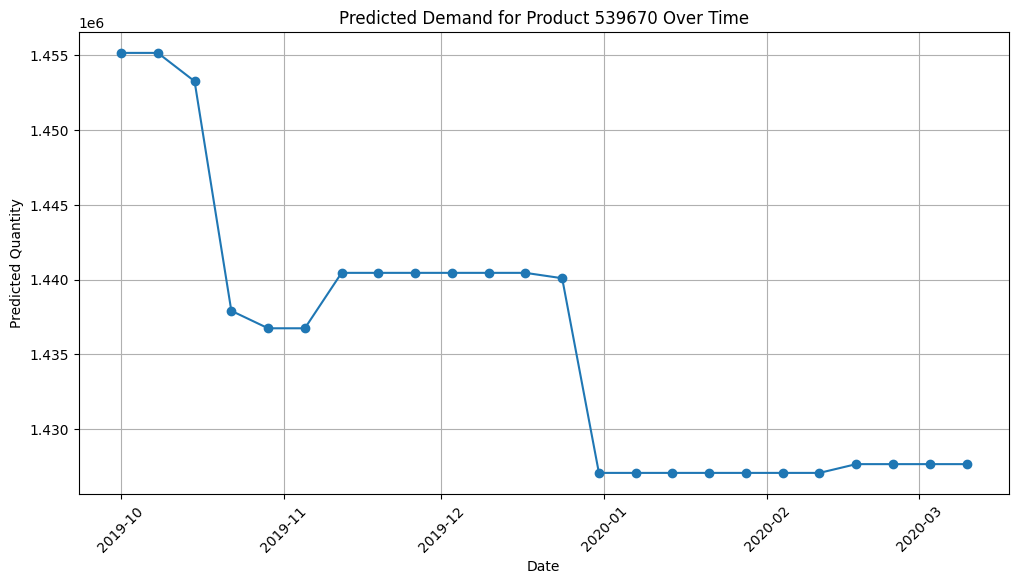

In [35]:
top_product_id = product_sum_predictions.idxmax()

# Filter future_df for the top product
top_product_predictions = future_df[future_df['product_id'] == top_product_id]

# Create a line chart
plt.figure(figsize=(12, 6))
plt.plot(top_product_predictions['date'], top_product_predictions['predicted_quantity'], marker='o')
plt.title(f'Predicted Demand for Product {top_product_id} Over Time')
plt.xlabel('Date')
plt.ylabel('Predicted Quantity')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


<a id="out"></a>
### 6.3 Demand Forcast for top product which were out of stock 

In [6]:
from datetime import datetime, timedelta
import pandas as pd
from joblib import load 

# Load the RandomForest model
model = joblib.load('random_forest_final_Demand_model.joblib')

# Step 1: Identify the top 20 products with zero in their sales_net column
zero_sales_net_products = transaction_data[transaction_data['sales_net'] == 0]
top_zero_sales_net_products = zero_sales_net_products['product_id'].value_counts().head(20).index.tolist()

# Assuming you have a future dates setup as in your original code
start_date = datetime(2019, 10, 1)
future_dates = [start_date + timedelta(weeks=w) for w in range(24)]

# Create the prediction DataFrame for the identified products
future_df = pd.DataFrame([(date, pid) for date in future_dates for pid in top_zero_sales_net_products], columns=['date', 'product_id'])

# Initialize columns for lag and moving average features, as before
for lag in range(1, 5):
    future_df[f'quantity_lag_{lag}'] = None
future_df['quantity_ma_4'] = None

# Add 'week_of_year' and 'year' for these future dates
future_df['week_of_year'] = future_df['date'].dt.isocalendar().week
future_df['year'] = future_df['date'].dt.year

# Assuming weekly_sales DataFrame exists and contains historical data as in your setup
historical_data = weekly_sales[['date_order', 'product_id', 'quantity']].rename(columns={'date_order': 'date'})
historical_data['date'] = pd.to_datetime(historical_data['date'])

# Function to fill in the lag and moving average features for each row in future_df
def fill_features(row, historical_data):
    product_id = row['product_id']
    for lag in range(1, 5):
        lag_date = row['date'] - timedelta(weeks=lag)
        lag_quantity = historical_data[(historical_data['product_id'] == product_id) & 
                                       (historical_data['date'] == lag_date)]['quantity'].sum()
        row[f'quantity_lag_{lag}'] = lag_quantity
    
    ma_periods = historical_data[(historical_data['product_id'] == product_id) & 
                                 (historical_data['date'] < row['date'])].tail(4)['quantity']
    row['quantity_ma_4'] = ma_periods.mean() if not ma_periods.empty else 0
    
    return row

# Apply the function to fill features
future_df = future_df.apply(lambda row: fill_features(row, historical_data), axis=1)

# Ensure the features are in the correct order and dtype conversion for model compatibility
features = ['week_of_year', 'year', 'quantity_lag_1', 'quantity_lag_2', 'quantity_lag_3', 'quantity_lag_4', 'quantity_ma_4']
future_df[features] = future_df[features].astype(float)

# Predict using the RandomForest model
future_df['predicted_quantity'] = model.predict(future_df[features])

# Output for all products including those predicted to have zero demand
print(future_df[['date', 'product_id', 'predicted_quantity']])


          date  product_id  predicted_quantity
0   2019-10-01     2512504        50430.560000
1   2019-10-01     1075327         4010.540000
2   2019-10-01     3000784       127317.433333
3   2019-10-01     1366829       758305.740000
4   2019-10-01     2811481       328079.426667
..         ...         ...                 ...
475 2020-03-10      378845       200680.140000
476 2020-03-10     1733850         2006.840000
477 2020-03-10     1821870         3604.513333
478 2020-03-10     2564840       260267.640000
479 2020-03-10      693368         3203.893333

[480 rows x 3 columns]


<a id="outtotal"></a>
### 6.4 Bar chart showing the top out of stock prodcut total demand forcast 

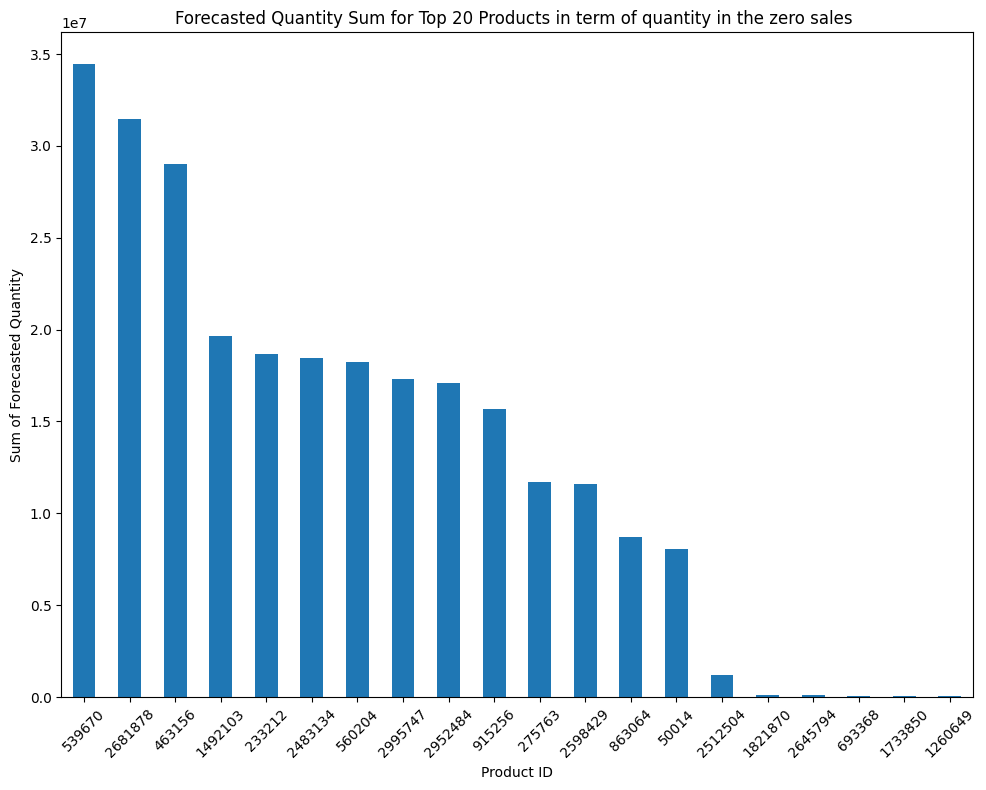

In [9]:
# Step 1: Sum the quantity for each product with zero in their sales_net column
zero_sales_net_products = transaction_data[transaction_data['sales_net'] == 0]
top_zero_sales_net_products = zero_sales_net_products.groupby('product_id')['quantity'].sum().nlargest(20).index.tolist()

# Assuming you have a future dates setup as in your original code
start_date = datetime(2019, 10, 1)
future_dates = [start_date + timedelta(weeks=w) for w in range(24)]

# Create the prediction DataFrame for the identified products
future_df = pd.DataFrame([(date, pid) for date in future_dates for pid in top_zero_sales_net_products], columns=['date', 'product_id'])

# Initialize columns for lag and moving average features, as before
for lag in range(1, 5):
    future_df[f'quantity_lag_{lag}'] = None
future_df['quantity_ma_4'] = None

# Add 'week_of_year' and 'year' for these future dates
future_df['week_of_year'] = future_df['date'].dt.isocalendar().week
future_df['year'] = future_df['date'].dt.year

# Assuming weekly_sales DataFrame exists and contains historical data as in your setup
historical_data = weekly_sales[['date_order', 'product_id', 'quantity']].rename(columns={'date_order': 'date'})
historical_data['date'] = pd.to_datetime(historical_data['date'])

# Function to fill in the lag and moving average features for each row in future_df
def fill_features(row, historical_data):
    product_id = row['product_id']
    for lag in range(1, 5):
        lag_date = row['date'] - timedelta(weeks=lag)
        lag_quantity = historical_data[(historical_data['product_id'] == product_id) & 
                                       (historical_data['date'] == lag_date)]['quantity'].sum()
        row[f'quantity_lag_{lag}'] = lag_quantity
    
    ma_periods = historical_data[(historical_data['product_id'] == product_id) & 
                                 (historical_data['date'] < row['date'])].tail(4)['quantity']
    row['quantity_ma_4'] = ma_periods.mean() if not ma_periods.empty else 0
    
    return row

# Apply the function to fill features
future_df = future_df.apply(lambda row: fill_features(row, historical_data), axis=1)

# Ensure the features are in the correct order and dtype conversion for model compatibility
features = ['week_of_year', 'year', 'quantity_lag_1', 'quantity_lag_2', 'quantity_lag_3', 'quantity_lag_4', 'quantity_ma_4']
future_df[features] = future_df[features].astype(float)

# Predict using the RandomForest model
future_df['predicted_quantity'] = model.predict(future_df[features])

# Aggregate predicted quantities for each product
product_forecast_sum = future_df.groupby('product_id')['predicted_quantity'].sum().sort_values(ascending=False)

# Plotting the sum of each product's forecasted quantity
plt.figure(figsize=(10, 8))
product_forecast_sum.plot(kind='bar')
plt.title('Forecasted Quantity Sum for Top 20 Products in term of quantity in the zero sales ')
plt.xlabel('Product ID')
plt.ylabel('Sum of Forecasted Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
